# Задание 1


Выберите 5 языков в википедии (не тех, что использовались в семинаре). Скачайте по 10 случайных статей для каждого языка. Предобработайте тексты, удаляя лишние теги/отступы/разделители (если они есть). Разделите тексты на предложения и создайте датасет, в котором каждому предложению соответствует язык. Кластеризуйте тексты, используя эбмединг модель из прошлого семинара и любой алгоритм кластеризации. Проверьте качество кластеризации с помощь метрики ARI.

In [11]:
import wikipedia
import numpy as np
import os
import json
import requests

### Скачать по 10 статей на 5 языках

In [12]:
# выбор и расшифровка 5 языков
code2lang = wikipedia.languages()
langs = ['es', 'fr', 'de', 'it', 'pt']
[(lang, code2lang[lang]) for lang  in langs]

[('es', 'español'),
 ('fr', 'français'),
 ('de', 'Deutsch'),
 ('it', 'italiano'),
 ('pt', 'português')]

In [22]:
def load_with_disambigution(page):
    try:
        p = wikipedia.page(page)
    except wikipedia.DisambiguationError as e:
        random_option = np.random.choice(e.options)
        p = wikipedia.page(random_option)
    return p

In [23]:
def get_texts_for_lang(lang, n=100): # функция для скачивания статей из википедии
    # вот так можно зафиксировать язык
    wikipedia.set_lang(lang)
    wiki_content = []
    
    # random достает только ссылки на статьи
    pages = wikipedia.random(n)
    
    for page_name in pages:
        try:
            # чтобы загрузить контент статьи можно вызвать функцию .page
            page = load_with_disambigution(page_name)
        
        except Exception as e:
            print('Skipping page {}'.format(page_name), e)
            continue

        wiki_content.append(f'{page.title}\n{page.content.replace("==", "")}')

    return wiki_content

In [26]:
%%time

wiki_texts = {}

for lang in langs:
    try:
        wikipedia.set_lang(lang)
        wiki_texts[lang] = get_texts_for_lang(lang, 10)
    except Exception as e:
        print('ERROR ON - ', lang, e)
        continue

    print(lang, len(wiki_texts[lang]))

es 10
fr 10
de 10
it 10
pt 10
CPU times: user 4.84 s, sys: 605 ms, total: 5.45 s
Wall time: 1min 56s


### Классификация языка на основе пересечения символов

In [27]:
from collections import defaultdict
from string import digits
import re

digits = set(digits)

In [48]:
# создаем словарь уникальных символов для каждого языка
lang2chars = defaultdict(set)

# проходимся по текстам для каждого языка в wiki_texts и добавляем уникальные буквы
# в соответствующее множество символов lang2chars
for lang in wiki_texts:
    for text in wiki_texts[lang]:
        char_set = set(re.findall("\w", text.lower())) - digits
        lang2chars[lang].update(char_set)

In [29]:
lang2chars.keys()

dict_keys(['es', 'fr', 'de', 'it', 'pt'])

In [34]:
# посмотрим на какой-нибудь язык
len(lang2chars['fr'])

60

In [37]:
# символы для этого языка
list(lang2chars['es'])[:10]

['a', 'l', 'm', 'q', 'v', 'ö', 'é', 'h', 'o', 'ő']

In [38]:
# функция предсказания языка статьи
def predict_language(text, lang2char):
    text_chars = set(re.findall('\w', text.lower())) - digits
    lang2sim = {}
    
    for lang in lang2char:
        intersect = len(text_chars & lang2char[lang])
        lang2sim[lang] = intersect
    
    return max(lang2sim.items(), key=lambda x: x[1])[0]
# функция возвращает язык, который имеет максимальное количество пересекающихся символов с text_chars

In [40]:
predict_language('какой это язык', lang2chars) # Неправильно:(

'it'

In [41]:
from sklearn.metrics import classification_report, confusion_matrix

In [42]:
# создаем 2 списка для хранения фактических и предсказанных языков для каждого текста
true_labels = []
predicted_labels = []

for lang in wiki_texts:
    for text in wiki_texts[lang]:
        true_labels.append(lang)
        predicted_labels.append(predict_language(text, lang2chars))

In [43]:
true_labels[0], predicted_labels[0]

('es', 'es')

In [44]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

          de       1.00      1.00      1.00        10
          es       0.77      1.00      0.87        10
          fr       0.77      1.00      0.87        10
          it       1.00      0.70      0.82        10
          pt       1.00      0.70      0.82        10

    accuracy                           0.88        50
   macro avg       0.91      0.88      0.88        50
weighted avg       0.91      0.88      0.88        50



In [45]:
labels = list(set(true_labels))
print(confusion_matrix(true_labels, predicted_labels, labels = labels))

[[10  0  0  0  0]
 [ 0 10  0  0  0]
 [ 0  0  7  3  0]
 [ 0  0  0 10  0]
 [ 3  0  0  0  7]]


In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

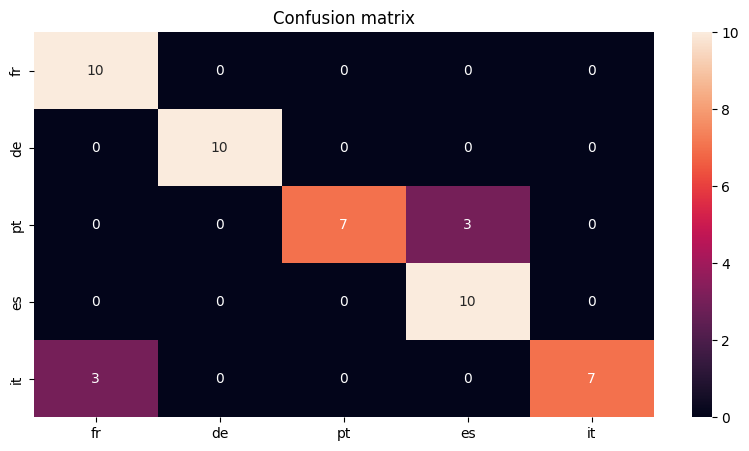

In [47]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=confusion_matrix(true_labels, predicted_labels, labels = labels), 
            annot=True, 
            fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
plt.title("Confusion matrix")
plt.show()

Путаются испанский с португальский, и французский с итальянский, поскольку языки похожи

### Предобработка текстов: удаление тегов, отступов, разделителей.  Деление на предложения и создание датасета

In [50]:
import re
from nltk.tokenize import sent_tokenize

# Функция для предобработки текста
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)  # Удаление HTML-тегов
    text = re.sub(r'\s+', ' ', text)    # Замена множественных пробелов на одиночные
    text = text.strip()                # Удаление начальных и конечных пробелов
    
    return text

# Функция для разделения текста на предложения
def split_text_into_sentences(text):
    sentences = sent_tokenize(text)
    return sentences

# Предобработка текстов для всех языков
preprocessed_texts = {}

for lang, texts in wiki_texts.items():
    preprocessed_texts[lang] = []
    for text in texts:
        preprocessed_text = preprocess_text(text)
        sentences = split_text_into_sentences(preprocessed_text)
        preprocessed_texts[lang].extend(sentences)

In [54]:
# проверим
for lang in preprocessed_texts:
    print(f"{lang}")
    for sentence in preprocessed_texts[lang][:3]:
        print(sentence)
    print("\n")

es
Épsilon Sculptoris Épsilon Sculptoris (ε Scl / HD 10830 / HR 514)[1]​ es un sistema estelar de magnitud aparente +5,29 situado en la constelación de Sculptor.
Se encuentra a 89,5 años luz del sistema solar.
La componente principal del sistema, Épsilon Sculptoris A, es una estrella blanco-amarilla de tipo F2V —muy semejante a η Corvi por ejemplo— con una temperatura efectiva de 6699 K. Es unas 5 veces más luminosa que el Sol y no parece existir unanimidad en cuanto a su contenido metálico; mientras que en un estudio su metalicidad es comparable a la solar,[2]​ para otra fuente su abundancia relativa de metales solo supone el 60% de la del Sol.


fr
Le Matin des magiciens Le Matin des magiciens, introduction au réalisme fantastique est un livre de Louis Pauwels et Jacques Bergier publié en octobre 1960 aux éditions Gallimard dans la « collection blanche ».
Le courant du « réalisme fantastique » annoncé par le titre secondaire fut aussi celui de Planète, lancée l'année suivante par les

In [55]:
# создадим датасет
dataset = []

for lang, sentences in preprocessed_texts.items():
    for sentence in sentences:
        dataset.append((sentence, lang))

In [57]:
import random

# Вывести случайные примеры из датасета
random_samples = random.sample(dataset, 5)
for sentence, lang in random_samples:
    print(f"Язык: {lang}\nПредложение: {sentence}\n")


Язык: es
Предложение: 14.

Язык: fr
Предложение: Description = Apparence = Le méliphage bruyant mesure entre 24 et 28 cm de long avec une envergure de 36 à 45 cm et un poids de 70 et 80 g. Les mâles, les femelles et les juvéniles ont un plumage similaire : gris sur le dos, la queue et la poitrine et blanc en dessous avec des festons blancs sur la nuque, l'arrière-cou et la poitrine ; noir sur le dessus de la tête et les joues ; un bec jaune-orange vif et une tache de peau nue jaune derrière l'œil ; une extrémité blanche à la queue ; une bordure verte sur l'aile et des pattes orange-jaune.

Язык: it
Предложение: Cardinale Lodovico Calini Vescovo Giovanni Benedetto CivranLa successione apostolica è: Vescovo Antonio Maria Ambiveri (1775) Arcivescovo Giuseppe Gregorio Scotti (1790) Note Voci correlate Civran Diocesi di Caorle Diocesi di Chioggia Collegamenti esterni (EN) David M. Cheney, Giovanni Benedetto Civran, in Catholic Hierarchy.

Язык: fr
Предложение: La course est remportée en sol

### Кластеризация текстов, используя эбмединг модель из прошлого семинара и K-Means

In [59]:
from sklearn.metrics.pairwise import cosine_distances
from sentence_transformers import SentenceTransformer

In [60]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [63]:
%%time
embeddings = model.encode([sentence for sentence, lang in dataset])

CPU times: user 4min 37s, sys: 17.5 s, total: 4min 54s
Wall time: 4min 45s


In [66]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, n_init=10)
clusters = kmeans.fit_predict(embeddings)

### Проверка качества кластеризации с помощь метрики ARI

In [70]:
from sklearn.metrics import adjusted_rand_score
true_labels = [true_lang for sentence, true_lang in dataset]
ari = adjusted_rand_score(true_labels, clusters)
print (ari)

0.6686119940559555


# Задание 2

Загрузите корпус `annot.opcorpora.no_ambig_strict.xml.bz2` с OpenCorpora. Найдите в корпусе самые частотные морфологически омонимичные словоформы (те, которым соответствует разный грамматический разбор). Также найдите словоформы с самых большим количеством вариантов грамматических разборов.

In [71]:
!wget https://opencorpora.org/files/export/annot/annot.opcorpora.no_ambig_strict.xml.bz2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--2023-10-16 14:22:16--  https://opencorpora.org/files/export/annot/annot.opcorpora.no_ambig_strict.xml.bz2
Распознаётся opencorpora.org (opencorpora.org)… 104.21.15.199, 172.67.163.210
Подключение к opencorpora.org (opencorpora.org)|104.21.15.199|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 1435269 (1,4M) [application/x-bzip2]
Сохранение в: «annot.opcorpora.no_ambig_strict.xml.bz2»

annot.opcorpora.no_ 100%[===================>]   1,37M   713KB/s    за 2,0s    

2023-10-16 14:22:19 (713 KB/s) - «annot.opcorpora.no_ambig_strict.xml.bz2» сохранён [1435269/1435269]



In [72]:
import bz2

with bz2.open('annot.opcorpora.no_ambig_strict.xml.bz2', 'rb') as f_in, open('annot.opcorpora.no_ambig_strict.xml', 'wb') as f_out:
    f_out.write(f_in.read())

In [74]:
#!pip install lxml

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Obtaining dependency information for lxml from https://files.pythonhosted.org/packages/d6/56/9d5cb3438143a5aebad59088ca392950d74a531e1b96d0959144370b3b59/lxml-4.9.3-cp311-cp311-macosx_11_0_universal2.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 408.4 kB/s eta 0:00:0000:0100:01


In [75]:
from lxml import etree
from pymorphy2 import MorphAnalyzer
from sklearn.metrics import classification_report
import numpy as np
from collections import Counter

In [76]:
open_corpora = etree.fromstring(open('annot.opcorpora.no_ambig_strict.xml', 'rb').read())

In [77]:
## чтобы не прописывать весь путь до tokens можно поставить // - он проверит все возможные варианты пока не дойдет до tokens
sentences = open_corpora.xpath('//tokens')

In [78]:
# тут просто обращение по тэгу
tokens = sentences[0].xpath('token')

In [79]:
# text хранится в атрибуте, к нему можно обратится через @
[token.xpath('@text')[0] for token in tokens]

['«', 'Школа', 'злословия', '»', 'учит', 'прикусить', 'язык']

In [80]:
# грамматическая иформация чуть более вложена
[token.xpath('tfr/v/l/g/@v')[0] for token in tokens]

['PNCT', 'NOUN', 'NOUN', 'PNCT', 'VERB', 'INFN', 'NOUN']

In [81]:
corpus = []


for sentence in open_corpora.xpath('//tokens'):
    sent_tagged = []
    for token in sentence.xpath('token'):
        word = token.xpath('@text')
        gram_info = token.xpath('tfr/v/l/g/@v')
        sent_tagged.append([word[0]] + gram_info)
    
    corpus.append(sent_tagged)
        

In [138]:
# пример предложения с разметкой
corpus[100]

[['Обструкция', 'NOUN', 'inan', 'femn', 'sing', 'nomn'],
 ['Синявскому', 'NOUN', 'anim', 'masc', 'Sgtm', 'Surn', 'sing', 'datv'],
 ['после', 'PREP'],
 ['«', 'PNCT'],
 ['Прогулок', 'NOUN', 'inan', 'femn', 'plur', 'gent'],
 ['с', 'PREP'],
 ['Пушкиным', 'NOUN', 'anim', 'masc', 'Sgtm', 'Surn', 'sing', 'ablt'],
 ['»', 'PNCT'],
 ['—', 'PNCT'],
 ['кадрами', 'NOUN', 'inan', 'masc', 'plur', 'ablt'],
 ['волка', 'NOUN', 'anim', 'masc', 'sing', 'gent'],
 ['в', 'PREP'],
 ['клетке', 'NOUN', 'inan', 'femn', 'sing', 'loct'],
 ['с', 'PREP'],
 ['табличкой', 'NOUN', 'inan', 'femn', 'sing', 'ablt'],
 ['«', 'PNCT'],
 ['Danger', 'LATN'],
 ['»', 'PNCT'],
 ['.', 'PNCT']]

### Поиск частотных морфологически омонимичных словоформ

In [124]:
from collections import Counter

In [164]:
from collections import defaultdict

# словарь для хранения информации о словоформах
word_forms_info = defaultdict(list)

# пегулярное выражение для токенов, которые могут содержать буквы и дефисы
word_pattern = re.compile(r"^[A-Za-zА-Яа-яЁё-]+$")

# проходимся по предложениям в корпусе
for sentence in open_corpora.xpath('//tokens'):
    for token in sentence.xpath('token'):
        word = token.xpath('@text')[0]
        gram_info = token.xpath('tfr/v/l/g/@v')

        # проверка, что токен состоит только из букв
        if word_pattern.match(word):
            gram_info_list = gram_info
            # переделаем грамматическую информации в список для сравнения
            gram_info_str = "|".join(gram_info_list)
            # обновляем словарь с информацией о словоформе
            word_forms_info[word].append(gram_info_str)

# создаем словарь со статистикой
word_forms2 = {}

# проходимся по словарю с информацией о словоформах
for word, gram_info_list in word_forms_info.items():
    if len(gram_info_list) > 1:
        # подсчет частотности словоформы
        word_frequency = len(gram_info_list)

        # подсчитываем количества вариантов грамматического разбора
        grammatical_variants_count = len(set(gram_info_list))

        # запись информации о словоформе в словарь словоформ
        word_forms2[word] = {
            "word_frequency": word_frequency,
            "grammatical_variants_count": grammatical_variants_count,
            "grammatical_variants": list(set(gram_info_list)),
        }

In [165]:
# выводим результаты
for word, info in word_forms2.items():
    print(f"Словоформа: {word}")
    print(f"Частотность: {info['word_frequency']}")
    print(f"Количество вариантов грамматического разбора: {info['grammatical_variants_count']}")
    print(f"Варианты грамматического разбора: {info['grammatical_variants']}")
    print()



Словоформа: Школа
Частотность: 3
Количество вариантов грамматического разбора: 1
Варианты грамматического разбора: ['NOUN|inan|femn|sing|nomn']

Словоформа: злословия
Частотность: 2
Количество вариантов грамматического разбора: 1
Варианты грамматического разбора: ['NOUN|inan|neut|sing|gent']

Словоформа: дискуссии
Частотность: 2
Количество вариантов грамматического разбора: 2
Варианты грамматического разбора: ['NOUN|inan|femn|sing|gent', 'NOUN|inan|femn|sing|loct']

Словоформа: в
Частотность: 1583
Количество вариантов грамматического разбора: 2
Варианты грамматического разбора: ['PREP', 'NOUN|inan|masc|Fixd|Abbr|sing|gent']

Словоформа: новом
Частотность: 5
Количество вариантов грамматического разбора: 1
Варианты грамматического разбора: ['ADJF|Qual|masc|sing|loct']

Словоформа: сезоне
Частотность: 2
Количество вариантов грамматического разбора: 1
Варианты грамматического разбора: ['NOUN|inan|masc|sing|loct']

Словоформа: вернулась
Частотность: 4
Количество вариантов грамматического ра

In [166]:
# Создаем словарь для хранения информации о морфологически омонимичных словоформах
omonymous_word_forms = {}

# Проходимся по словарю с информацией о словоформах
for word, info in word_forms2.items():
    if info['grammatical_variants_count'] >= 2:
        # Если количество вариантов грамматического разбора больше или равно двум, сохраняем информацию
        omonymous_word_forms[word] = info

# Выводим отфильтрованные результаты
for word, info in omonymous_word_forms.items():
    print(f"Словоформа: {word}")
    print(f"Частотность: {info['word_frequency']}")
    print(f"Количество вариантов грамматического разбора: {info['grammatical_variants_count']}")
    print(f"Варианты грамматического разбора: {info['grammatical_variants']}")
    print()


Словоформа: дискуссии
Частотность: 2
Количество вариантов грамматического разбора: 2
Варианты грамматического разбора: ['NOUN|inan|femn|sing|gent', 'NOUN|inan|femn|sing|loct']

Словоформа: в
Частотность: 1583
Количество вариантов грамматического разбора: 2
Варианты грамматического разбора: ['PREP', 'NOUN|inan|masc|Fixd|Abbr|sing|gent']

Словоформа: проект
Частотность: 3
Количество вариантов грамматического разбора: 2
Варианты грамматического разбора: ['NOUN|inan|masc|sing|nomn', 'NOUN|inan|masc|sing|accs']

Словоформа: с
Частотность: 536
Количество вариантов грамматического разбора: 2
Варианты грамматического разбора: ['PRCL', 'PREP']

Словоформа: на
Частотность: 686
Количество вариантов грамматического разбора: 2
Варианты грамматического разбора: ['PRCL', 'PREP']

Словоформа: же
Частотность: 11
Количество вариантов грамматического разбора: 2
Варианты грамматического разбора: ['CONJ', 'PRCL']

Словоформа: одной
Частотность: 21
Количество вариантов грамматического разбора: 4
Варианты гр

In [167]:
# Сортируем словарь по частотности в убывающем порядке и выбираем топ 10
sorted_omonymous_word_forms1 = sorted(omonymous_word_forms.items(), key=lambda x: x[1]['word_frequency'], reverse=True)[:10]

# Выводим топ 10 самых частотных грамматически омонимичных словоформ
for word, info in sorted_omonymous_word_forms1:
    print(f"Словоформа: {word}")
    print(f"Частотность: {info['word_frequency']}")
    print(f"Количество вариантов грамматического разбора: {info['grammatical_variants_count']}")
    print(f"Варианты грамматического разбора: {info['grammatical_variants']}")
    print()


Словоформа: в
Частотность: 1583
Количество вариантов грамматического разбора: 2
Варианты грамматического разбора: ['PREP', 'NOUN|inan|masc|Fixd|Abbr|sing|gent']

Словоформа: на
Частотность: 686
Количество вариантов грамматического разбора: 2
Варианты грамматического разбора: ['PRCL', 'PREP']

Словоформа: с
Частотность: 536
Количество вариантов грамматического разбора: 2
Варианты грамматического разбора: ['PRCL', 'PREP']

Словоформа: и
Частотность: 507
Количество вариантов грамматического разбора: 2
Варианты грамматического разбора: ['CONJ', 'PRCL']

Словоформа: году
Частотность: 115
Количество вариантов грамматического разбора: 2
Варианты грамматического разбора: ['NOUN|inan|masc|sing|loc2', 'NOUN|inan|masc|sing|datv']

Словоформа: этом
Частотность: 104
Количество вариантов грамматического разбора: 3
Варианты грамматического разбора: ['NPRO|neut|sing|loct', 'ADJF|Subx|Apro|Anph|neut|sing|loct', 'ADJF|Subx|Apro|Anph|masc|sing|loct']

Словоформа: России
Частотность: 90
Количество вариант

### Поиск самых морфологически омонимичных словоформ

In [171]:
# Сортируем словарь по количеству вариантов грамматического разбора в убывающем порядке и выбираем топ 10
sorted_omonymous_word_forms2 = sorted(omonymous_word_forms.items(), key=lambda x: x[1]['grammatical_variants_count'], reverse=True)[:10]

# Выводим топ 10 словоформ с наибольшим количеством вариантов грамматического разбора
for word, info in sorted_omonymous_word_forms2:
    print(f"Словоформа: {word}")
    print(f"Частотность: {info['word_frequency']}")
    print(f"Количество вариантов грамматического разбора: {info['grammatical_variants_count']}")
    print(f"Варианты грамматического разбора: {info['grammatical_variants']}")
    print()


Словоформа: США
Частотность: 44
Количество вариантов грамматического разбора: 6
Варианты грамматического разбора: ['NOUN|inan|GNdr|Pltm|Fixd|Abbr|Geox|plur|nomn', 'NOUN|inan|GNdr|Pltm|Fixd|Abbr|Geox|plur|accs', 'NOUN|inan|GNdr|Pltm|Fixd|Abbr|Geox|plur|datv', 'NOUN|inan|GNdr|Pltm|Fixd|Abbr|Geox|plur|loct', 'NOUN|inan|GNdr|Pltm|Fixd|Abbr|Geox|plur|gent', 'NOUN|inan|GNdr|Pltm|Fixd|Abbr|Geox|plur|ablt']

Словоформа: кино
Частотность: 12
Количество вариантов грамматического разбора: 5
Варианты грамматического разбора: ['NOUN|inan|neut|Fixd|sing|nomn', 'NOUN|inan|neut|Fixd|sing|gent', 'NOUN|inan|neut|Fixd|sing|accs', 'NOUN|inan|neut|Fixd|sing|datv', 'NOUN|inan|neut|Fixd|sing|loct']

Словоформа: евро
Частотность: 15
Количество вариантов грамматического разбора: 5
Варианты грамматического разбора: ['NOUN|inan|neut|Fixd|sing|nomn', 'NOUN|inan|neut|Fixd|sing|gent', 'NOUN|inan|neut|Fixd|sing|accs', 'NOUN|inan|neut|Fixd|plur|gent', 'NOUN|inan|neut|Fixd|sing|datv']

Словоформа: компании
Частотность

## Задание 3 (не получилось скачать модель udpipe)
Загрузите один из файлов корпуса Syntagrus - https://github.com/UniversalDependencies/UD_Russian-SynTagRus/tree/master (можно взять тестовый)

Преобразуйте все разборы предложений в графовые структуру через DependencyGraph, выберите отношение (из тех, что не упоминались на семинаре) и найдите самые частотные пары слов, связанных этим отношением. 

Для самой частотной пары вытащите все подзависимые слова для каждого из них во всех предложениях (используя `flatten(get_subtree(d.nodes, index_of_a_word)`) В итоге у вас должен получится список пары: слово1 и все его подзависимые - слово2 и все его подзависимые.

Визуализируйте самое длинное предложение через networkx

In [172]:
!pip install ufal.udpipe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 kB 1.4 MB/s eta 0:00:0000:0100:01


In [59]:
import spacy_udpipe
spacy_udpipe.download("ru")

HTTPError: HTTP Error 451: 

In [173]:
!pip install spacy-udpipe

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [55]:
import spacy_udpipe

In [56]:
import spacy_udpipe

model = "ru_syntagrus.model.zip"

# Загрузка модели
nlp = spacy_udpipe.load(model)


AssertionError: 'ru_syntagrus.model.zip' language not available

In [48]:
!wget http://download.tensorflow.org/models/parsey_universal/Russian-SynTagRus/ \
      russian-syntagrus-ud-2.4-190531.udpipe -O russian-syntagrus-ud-2.4-190531.udpipe


--2023-10-16 17:44:35--  http://download.tensorflow.org/models/parsey_universal/Russian-SynTagRus/
Распознаётся download.tensorflow.org (download.tensorflow.org)… 74.125.131.207, 64.233.162.207, 173.194.73.207, ...
Подключение к download.tensorflow.org (download.tensorflow.org)|74.125.131.207|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 403 Forbidden
2023-10-16 17:44:35 ОШИБКА 403: Forbidden.

--2023-10-16 17:44:35--  http://russian-syntagrus-ud-2.4-190531.udpipe/
Распознаётся russian-syntagrus-ud-2.4-190531.udpipe (russian-syntagrus-ud-2.4-190531.udpipe)… ошибка: nodename nor servname provided, or not known.
wget: не удаётся разрешить адрес «russian-syntagrus-ud-2.4-190531.udpipe»


In [45]:
with open("ru_syntagrus-ud-test.conllu", "r", encoding="utf-8") as file:
    data = file.read()

In [57]:
nlp = spacy_udpipe.load("ru")

Exception: Use spacy_udpipe.download to download the pre-trained UDPipe model for the 'ru' language